# Satellite Data Explorer and Downloader using SentinelHub

This notebook demonstrates how to download datasets from Sentinel Hub, a platform for managing and accessing satellite imagery and geospatial data. By using Sentinel Hub's robust [API](https://dataspace.copernicus.eu/analyse/apis), users can retrieve, process, and analyze satellite imagery tailored to specific needs. This is particularly valuable for applications such as environmental monitoring, geospatial analysis, and research.

**Key Features of This Notebook:**
* **Purpose**: Access and download satellite imagery via Sentinel Hub.
* **Use Cases**: Support data filtering and generating various indices.

**Information on Dataest:**
* Library: [Sentinelhub](https://sentinelhub-py.readthedocs.io/en/latest/index.html)
* Author: str.ucture GmbH
* Notebook Version: 1.1 (Updated: January 21, 2025)

## 1. Specifying the paths and working directories

In [32]:
import os

''' ---- Specify Directories Here ---- '''
download_folder = r".\data\sentinelhub\download"
images_folder = r".\data\sentinelhub\images"
''' ----- End of Declaration ---- '''

os.makedirs(download_folder, exist_ok=True)
os.makedirs(images_folder, exist_ok=True)

## 2. Filter and Retrieve Satellite Images Metadata

### 2.1 API and Authentication

The **Sentinel Hub API** is a powerful RESTful interface that provides access to satellite imagery from various sources, such as **Sentinel**, **Landsat**, and other Earth observation missions. This API enables users to:

* Retrieve raw satellite data
* Perform statistical analyses
* Visualize rendered images

This API is widely used for applications in fields like agriculture, forestry, environmental monitoring, and more.

#### **a. Authentication with OAuth2**

To interact with the Sentinel Hub API, **OAuth2** authentication is required. Follow these steps to set up your credentials and authenticate:

1. **Register an Account**  
   - Visit the [Copernicus Data Space Ecosystem](https://dataspace.copernicus.eu/) and create an account.
   - Once registered, log in to your account.

2. **Create an OAuth Client**  
   - Refer to the [OAuth Client Registration Guide](https://docs.sentinel-hub.com/api/latest/api/overview/authentication/#registering-oauth-client).
   - Generate a `client ID` and `client secret` for your application.

Alternatively, go to [Dashboard](https://shapps.dataspace.copernicus.eu/dashboard/#/) > User settings > Under OAuth clients select **+ Create**. > Fill in the information and Create. This will give you you `client ID` and `Client Secret`.

3. **Use Credentials for Access Tokens**  
   - Use the `client ID` and `client secret` to request access tokens, which are required to authenticate and authorize your API requests.
   - Replace the placeholder `client ID` and `client secret` values in the code below with your actual credentials.  

4. **One-Time Authentication**  
   - Authentication is required only once per computer system. After setting up and authenticating your credentials, you can proceed to the next steps without repeating the process.

#### **b. Quick Links**:
- **Register an Account**: [Copernicus Data Space Ecosystem](https://dataspace.copernicus.eu/)  
- **OAuth Client Setup**: [OAuth Client Guide](https://docs.sentinel-hub.com/api/latest/api/overview/authentication/#registering-oauth-client)


In [33]:
# # Uncomment and run this cell only if:
# # - You are running this code for the first time, AND
# # - You have not created a configuration.

# from sentinelhub import SHConfig

# # Initialize the Sentinel Hub configuration
# config = SHConfig()

# # Replace the placeholders below with your actual client ID and client secret
# config.sh_client_id = 'your-client-id-here'  # Example: '1234abcd-5678-efgh-ijkl-9876mnopqrst'
# config.sh_client_secret = 'your-client-secret-here'  # Example: 'a1b2c3d4e5f6g7h8i9j0klmnopqrst'

# # Set the base URL and token URL for Copernicus Data Space Ecosystem
# config.sh_base_url = 'https://sh.dataspace.copernicus.eu'
# config.sh_token_url = 'https://identity.dataspace.copernicus.eu/auth/realms/CDSE/protocol/openid-connect/token'

# # Save the configuration to a file named "cdse"
# config.save("cdse")

In [34]:
# Import required modules from sentinelhub
from sentinelhub import (
    SHConfig,
    DataCollection,
    SentinelHubCatalog,
    SentinelHubRequest,
    BBox,
    bbox_to_dimensions,
    CRS,
    MimeType,
    MosaickingOrder,
)

# Load the configuration from the "cdse" file
config = SHConfig("cdse")

# Check if the configuration has loaded properly
if not config.sh_client_id or not config.sh_client_secret:
    raise ValueError(
        "The configuration file 'cdse' is missing or incomplete. "
        "Ensure that you have created it with valid 'client ID' and 'client secret'."
    )

### 2.2 Define Data Query Parameters

You can filter satellite data using various parameters to narrow down the results based on your area of interest and specific analysis needs. Some of the key parameters include:

1. **Bounding Box Extents**: Define a geographic area of interest by specifying coordinates.
2. **Date Range**: Filter the data by providing a start and end date.
3. **Cloud Cover**: Limit the dataset to images with a specific range of cloud cover.
4. **Evaluation Scripts**: Use custom scripts to filter or process specific bands, useful for more advanced use cases. (Refer to Section 3.1 for details.)


#### 2.2.1. Define Bounding Box Extents, Bounding Box and  Size

The coordinates can be obtained using the  <a href="https://str-ucture.github.io/bbox-extractor/" target="_blank">BBox Extractor</a> tool.

*BBox Extractor is a web-based tool that helps users interactively select and generate bounding box coordinates in WGS84 format (latitude/longitude). This is especially useful when working with APIs or datasets that require a geographic area input.*

In [35]:
# Define the bounding box extents in CRS: WGS84 format [lon_min, lat_min, lon_max, lat_max]
bbox_wgs84 = [9.1170, 47.6330, 9.2180, 47.7160]  # Bounding box for Konstanz, Germany
resolution = 10  # Sentinel-2 primary bands have a spatial resolution of 10m

# Create a BBox object and calculate the dimensions of the bounding box based on the resolution
aoi_bbox = BBox(bbox=bbox_wgs84, crs=CRS.WGS84)
aoi_size = bbox_to_dimensions(aoi_bbox, resolution=resolution)

# Reference documentation for Sentinel-2 bands and resolution
# Learn more: https://docs.sentinel-hub.com/api/latest/data/sentinel-2-l1c/

#### 2.2.2 Define Date Range for searching Satellite Data

In [36]:
import ipywidgets as widgets
import datetime

# Create a DatePicker widget for selecting the initial date
initial_date = widgets.DatePicker(
    description="Select initial date: ",
    style=dict(description_width='initial'),
    disabled=False,
    value=datetime.date(2024,1,1)
    )

# Display the DatePicker widget
display(initial_date)

DatePicker(value=datetime.date(2024, 1, 1), description='Select initial date: ', step=1, style=DescriptionStyl…

In [37]:
# Create a DatePicker widget for selecting the final date
final_date = widgets.DatePicker(
    description="Select final date: ",
    style=dict(description_width='initial'),
    disabled=False,
    value=datetime.date.today()
    )

# Display the DatePicker widget
display(final_date)

DatePicker(value=datetime.date(2025, 3, 5), description='Select final date: ', step=1, style=DescriptionStyle(…

In [38]:
# Ensure the time interval is set only if both dates have valid values
if initial_date.value and final_date.value:
    # Create a tuple for the time interval with the selected start and end dates
    time_interval = (str(initial_date.value), str(final_date.value))
    print(f"Time interval successfully set: {time_interval}")
else:
    # Raise an error if either date is missing
    raise ValueError("Both initial and final dates must be selected to define the time interval.")

Time interval successfully set: ('2024-01-01', '2025-03-05')


#### 2.2.3 Define Maximum Cloud Cover in Percentage

In [39]:
# Create a BoundedIntText widget for specifying the cloud cover percentage
cloud_cover_input = widgets.BoundedIntText(
    value=20,
    min=0,
    max=100,
    step=10,
    description="Cloud Cover (%):",
    style={"description_width": "initial"},
    )

# Display the cloud cover input widget
display(cloud_cover_input)

BoundedIntText(value=20, description='Cloud Cover (%):', step=10, style=DescriptionStyle(description_width='in…

### 2.3 Retrieve Filtered Dataset Using SentinelHubCatalog

The **SentinelHubCatalog** is a powerful tool within the Sentinel Hub API that allows users to search and retrieve metadata for satellite imagery datasets. It provides advanced filtering capabilities based on various parameters, such as:

* **Time Range**: Filter by specific dates or time intervals.
* **Area of Interest (AoI)**: Define the geographic region for the dataset.
* **Cloud Cover**: Filter images based on the percentage of cloud cover.
* **Data Collection Types**: Choose from various data collections (e.g., Sentinel-2, Landsat).

*This tool simplifies the process of identifying and retrieving relevant imagery by enabling efficient filtering based on these criteria.*

In [40]:
import pandas as pd

# Initialize the SentinelHubCatalog with the configuration
catalog = SentinelHubCatalog(config=config)

# Search the Sentinel-2 L2A data collection using the defined parameters
search_iterator = catalog.search(
    DataCollection.SENTINEL2_L2A,
    bbox=aoi_bbox,
    time=time_interval,
    filter=f"eo:cloud_cover <= {cloud_cover_input.value}",
)

# Convert the search results into a list
results = list(search_iterator)
print("Total number of results:", len(results))

# Process the results into a structured list of dictionaries
data = []
for entry in results:
    id = entry['id']
    dt = entry['properties']['datetime']
    date, time = dt.split('T')
    time = time.replace('Z', '')
    cloud_cover = entry['properties']['eo:cloud_cover']
    data.append({
        'Date':date,
        'Time':time,
        'Cloud Cover (%)':cloud_cover,
        'Id':id,}),
    
# Convert the list into a Pandas DataFrame and display the first 5 rows
df = pd.DataFrame(data).sort_values(by='Cloud Cover (%)').reset_index(drop=True)
df.head(8)

Total number of results: 45


Date          Time  Cloud Cover (%)  \
0  2024-09-07  10:27:40.714             0.00   
1  2024-09-07  10:27:39.135             0.04   
2  2024-08-23  10:27:45.974             0.08   
3  2024-02-03  10:37:36.934             0.08   
4  2024-12-16  10:27:44.705             0.09   
5  2024-02-03  10:37:41.626             0.16   
6  2024-12-16  10:28:16.069             0.33   
7  2024-08-23  10:27:44.048             0.37   

                                                  Id  
0  S2A_MSIL2A_20240907T102021_N0511_R065_T32TMT_2...  
1  S2A_MSIL2A_20240907T102021_N0511_R065_T32TNT_2...  
2  S2B_MSIL2A_20240823T101559_N0511_R065_T32TMT_2...  
3  S2A_MSIL2A_20240203T103231_N0510_R108_T32TNT_2...  
4  S2A_MSIL2A_20241216T102431_N0511_R065_T32TMT_2...  
5  S2A_MSIL2A_20240203T103231_N0510_R108_T32TMT_2...  
6  S2C_MSIL2A_20241216T102501_N9905_R065_T32TMT_2...  
7  S2B_MSIL2A_20240823T101559_N0511_R065_T32TNT_2...

In [41]:
# Additional filtering to select only the images from summer months (June, July and August)
df['Date'] = pd.to_datetime(df['Date'])
filtered_df = df[df['Date'].dt.month.isin([6, 7, 8])].reset_index(drop=True)
filtered_df.head(3)

Date          Time  Cloud Cover (%)  \
0 2024-08-23  10:27:45.974             0.08   
1 2024-08-23  10:27:44.048             0.37   
2 2024-08-11  10:37:42.547             0.87   

                                                  Id  
0  S2B_MSIL2A_20240823T101559_N0511_R065_T32TMT_2...  
1  S2B_MSIL2A_20240823T101559_N0511_R065_T32TNT_2...  
2  S2A_MSIL2A_20240811T103031_N0511_R108_T32TNT_2...

## 3. Download and Visualize Satellite Data

### 3.1 Evaluation scripts for Satellite Data processing

Evaluation scripts **(evalscript)** in the Sentinel Hub API are used to customize the processing and visualization of satellite imagery data. These scripts allow you to select bands, compute indices (e.g., *NDVI*), apply custom visualizations, and filter or mask data. They are executed server-side to deliver processed outputs, such as images or numerical values, tailored to specific user needs. By using evaluation scripts, you can optimize data handling and focus on the precise information required for remote sensing analysis or applications.

> **WARNING!!: Do not modify the evaluation scripts unless you are confident in your changes**

For a comprehensive collection of evaluation scripts and a detailed guide on how to use them, visit the official Sentinel Hub documentation, [Sentinelhub Evalscript Documentation](https://docs.sentinel-hub.com/api/latest/evalscript/v3/). This resource provides in-depth explanations, syntax guidelines, and practical examples to help you create and modify evaluation scripts for processing satellite imagery efficiently.

In [42]:
evalscript_sentinel2_all_bands = """
    //VERSION=3
    function setup() {
        return {
            input: [{
                bands: ["B01","B02","B03","B04","B05","B06","B07","B08","B8A","B09","B10","B11","B12"],
                units: "DN"
            }],
            output: {
                bands: 13,
                sampleType: "INT16"
            }
        };
    }
    function evaluatePixel(sample) {
        return [sample.B01, 
                sample.B02,
                sample.B03,
                sample.B04,
                sample.B05,
                sample.B06,
                sample.B07,
                sample.B08,
                sample.B8A,
                sample.B09,
                sample.B10,
                sample.B11,
                sample.B12];
    }
"""

### 3.2 Request Satellite Data and Visualize

#### 3.2.1 Request Data Collection and Acquire Satellite Image with Least Cloud Cover (Least_CC)

> Note: The Least_CC method helps optimize the data quality, especially when cloud coverage can affect the clarity of the image. Ensure to specify this in your request to maximize the chances of receiving clear imagery.

In [43]:
# Define a request to download all Sentinel-2 bands
request_all_bands = SentinelHubRequest(
    data_folder = download_folder,
    evalscript=evalscript_sentinel2_all_bands,
    input_data=[
        SentinelHubRequest.input_data(
            data_collection=DataCollection.SENTINEL2_L1C.define_from(
                "s2l1c",
                service_url=config.sh_base_url
            ),
            time_interval=time_interval,
            mosaicking_order=MosaickingOrder.LEAST_CC,
        )
    ],
    responses=[SentinelHubRequest.output_response("default", MimeType.TIFF)],
    bbox=aoi_bbox,
    size=aoi_size,
    config=config,
)

# Request and retrieve the data (without saving it locally)
all_bands_response = request_all_bands.get_data(save_data=False)

#### 3.2.2 Define a function to plot the Satellite Data

In [44]:
import matplotlib.pyplot as plt
import numpy as np
from typing import Any, Optional, Tuple

def plot_image(
    image: np.ndarray,
    factor: float = 1.0,
    clip_range: Optional[Tuple[float, float]] = None,
    figsize: Tuple[float, float] = (15, 15),
    show_axis: bool = False,  # Added option to display axis
    **kwargs: Any
) -> None:
    """
    Utility function for plotting RGB images.

    Parameters:
        image (np.ndarray): The image array to plot. Expected shape is (height, width, channels).
        factor (float, optional): Scaling factor to adjust image intensity. Default is 1.0.
        clip_range (Tuple[float, float], optional): Range for clipping image intensity values.
            If provided, image values are clipped to this range.
        figsize (Tuple[float, float], optional): Size of the figure in inches. Default is (15, 15).
        show_axis (bool, optional): Whether to display axis ticks. Default is False.
        **kwargs (Any): Additional keyword arguments passed to plt.imshow.

    Returns:
        None: The function displays the image using matplotlib.
    """
    # Create a figure and axis for plotting
    fig, ax = plt.subplots(figsize=figsize)
    
    # Apply scaling and optional clipping to the image
    image_to_display = np.clip(image * factor, *clip_range) if clip_range is not None else image * factor
    
    # Display the image
    ax.imshow(image_to_display, **kwargs)
    
    # Conditionally remove axis ticks for a cleaner image display
    if not show_axis:
        ax.set_xticks([])
        ax.set_yticks([])
        ax.axis('off')

### 3.2.3 Visualize Satellite Image in True Color (RGB)

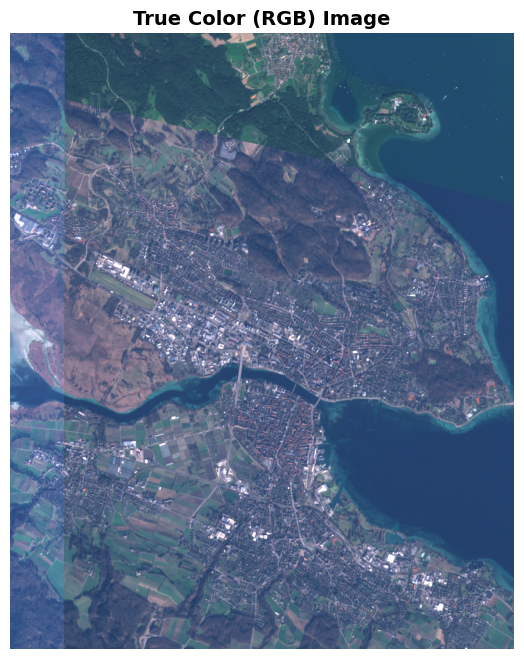

In [45]:
# Retrieve the first image from all_bands_response
image = all_bands_response[0]

# Calculate intensity range for scaling and clipping
min_val = np.percentile(image, 2) # 2nd percentile for lower bound
max_val = np.percentile(image, 98) # 98th percentile for upper bound

# Calculate scaling factor based on the maximum value
factor = 1.0 / max_val

# Apply a multiplier to adjust the intensity further
factor_multiplier = 1.4

# Plot the image in true color (RGB) using the calculated scaling factor
plot_image(
    image[:, :, [3, 2, 1]], # Band indices for Red, Green, and Blue (B04, B03, B02)
    factor=factor * factor_multiplier, # Apply factor and multiplier to scale intensity
    clip_range=(0, 1), # Clip the intensity to the range [0, 1]
    figsize=(8, 8)
)

# Set title for the plot
plt.title("True Color (RGB) Image", fontsize=14, fontweight='bold')
plt.show()

Sometimes, the request parameters—such as the time range and `mosaicking_order`-can result in poor-quality or undesirable mosaic satellite data. In such cases, it may be necessary to manually adjust the time interval to ensure that the desired satellite imagery is retrieved. For more details on how to modify the time range, refer to Section 2.3.

Additionally, the ability to directly access satellite data using a specific image ID is a valuable feature that holds significant potential. This feature warrants further exploration to fully understand its capabilities and how to implement it effectively.

In [46]:
# Example: Request data for the given parameters in the table "df"

# Define the time interval (modify based on specific requirements)
time_interval = '2024-08-23' # Adjust this value to filter by the desired date range

# Request satellite data based on the provided parameters
request_all_bands = SentinelHubRequest(
    data_folder=download_folder,
    evalscript=evalscript_sentinel2_all_bands,
    input_data=[
        SentinelHubRequest.input_data(
            data_collection=DataCollection.SENTINEL2_L1C.define_from(
                "s2l1c", service_url=config.sh_base_url
            ),
            time_interval=time_interval,
        )
    ],
    responses=[SentinelHubRequest.output_response("default", MimeType.TIFF)],
    bbox=aoi_bbox,
    size=aoi_size,
    config=config,
)

# Retrieve the satellite data
all_bands_response_v2 = request_all_bands.get_data(save_data=False)

# Change save_data=True to save the data locally
# all_bands_response_v3 = request_all_bands.get_data(save_data=True)

### 3.2.4 Visualize updated Satellite Image in True Color (RGB)

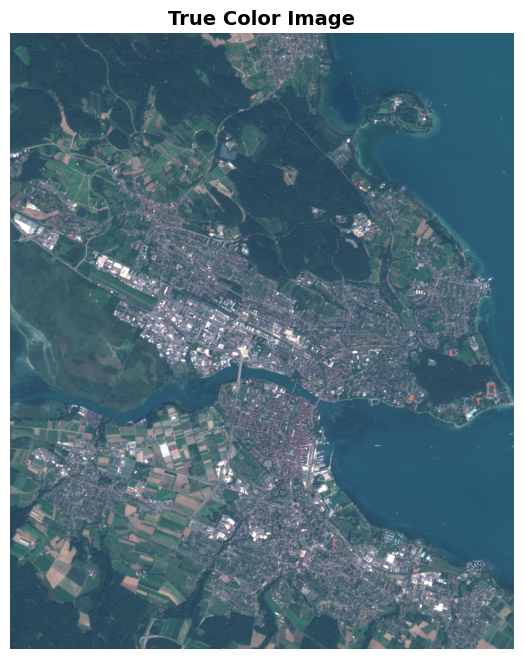

In [47]:
# Retrieve the first image from the response data
image = all_bands_response_v2[0]

# Calculate intensity range, scaling factor and adjust overall brightness
min_val = np.percentile(image, 2)
max_val = np.percentile(image, 98)
factor = 1.0 / max_val
factor_multiplier = 1.6

# Plot the image in true color (RGB) using the specified scaling and clipping range
plot_image(
    image[:, :, [3, 2, 1]],
    factor=factor * factor_multiplier,
    clip_range=(0, 1),
    figsize=(8, 8)
)

# Set title for the plot
plt.title("True Color Image", fontsize=14, fontweight='bold')
plt.show()

## 4. Save Image as a GeoTIFF Raster and PNG

An effective way to visualize and preserve the integrity of Sentinel-2 datasets is by saving them as a GeoTIFF file locally. GeoTIFF is a widely-used format that retains not only the image data but also essential geospatial metadata, such as geographic coordinates, projection information, and other properties. This makes it ideal for further analysis in GIS software, such as QGIS, ArcGIS, or other geospatial tools.

Saving your image in this format ensures that you can easily load, manipulate, and visualize the imagery while maintaining its spatial reference.

In [48]:
import rasterio
from rasterio.transform import from_bounds
from PIL import Image

# Define the shape and transformation parameters based on the image dimensions
height, width, bands = image.shape
transform = from_bounds(*bbox_wgs84, width=width, height=height)

# Extract RGB bands (Red, Green, Blue) and preprocess the image
rgb_image = image[:, :, [3, 2, 1]]
clipped_image = np.clip(rgb_image * factor * factor_multiplier, 0, 1)
uint8_image = (clipped_image * 255).astype(np.uint8)

# Define paths for saving the images
temp_tif = os.path.join(images_folder, f"sentinel2_all_bands_{time_interval}.tif")
temp_png = os.path.join(images_folder, f"sentinel2_rgb_{time_interval}.png")

# Ensure the download folder exists
os.makedirs(images_folder, exist_ok=True)

# Save the image as a GeoTIFF if it doesn't already exist
if not os.path.isfile(temp_tif):
    with rasterio.open(
        temp_tif,
        "w",
        driver="GTiff",
        height=height,
        width=width,
        count=3, # Only 3 bands for RGB
        dtype=uint8_image.dtype,
        crs="EPSG:4326", # WGS84 coordinate reference system
        transform=transform,
    ) as dst:
        for i in range(3): # Loop through the RGB bands
            dst.write(uint8_image[:, :, i], i + 1)
    print(f"GeoTIFF saved at: {temp_tif}")
else:
    print(f"GeoTIFF file already exists at: {temp_tif}")
    
# Save the image as a PNG file
if not os.path.isfile(temp_png):
    # Convert RGB array to PIL Image format and save as PNG
    pil_image = Image.fromarray(uint8_image, mode="RGB")
    pil_image.save(temp_png)
    print(f"PNG saved at: {temp_png}")
else:
    print(f"PNG file already exists at: {temp_png}")

GeoTIFF file already exists at: .\data\sentinelhub\images\sentinel2_all_bands_2024-08-23.tif
PNG file already exists at: .\data\sentinelhub\images\sentinel2_rgb_2024-08-23.png


## 5. Visualize True Color Raster using interractive map

Once the True Color raster is saved as a GeoTIFF file, it can be easily visualized using **Folium**.


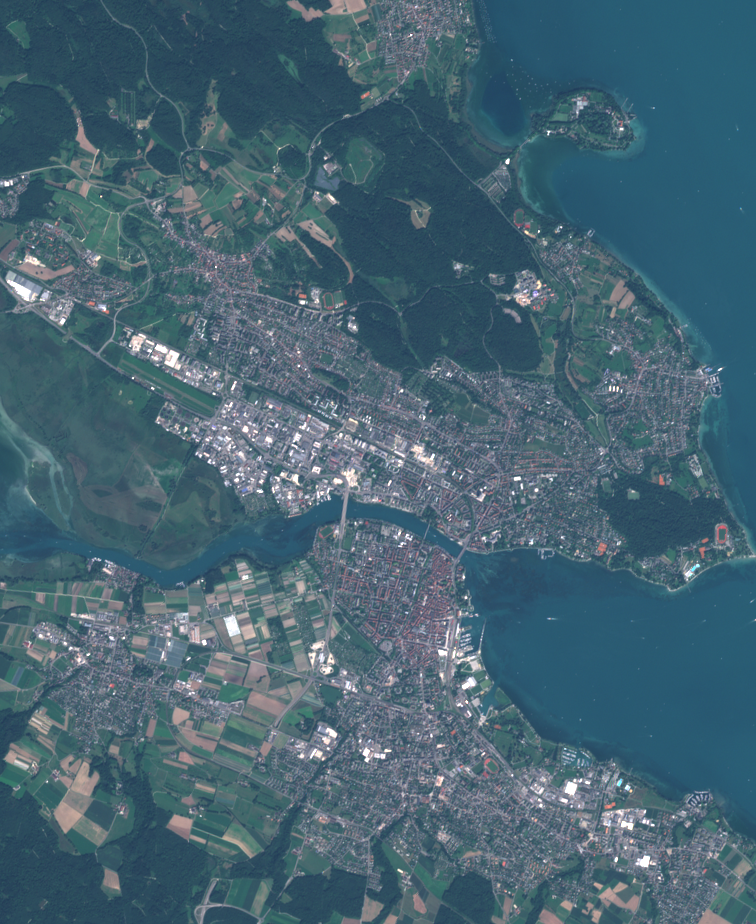

In [49]:
import folium
from folium.plugins import MiniMap, Fullscreen

# Create a Folium map centered around the bounding box
m = folium.Map(
    location=[(bbox_wgs84[1] + bbox_wgs84[3])/2, (bbox_wgs84[0] + bbox_wgs84[2])/2],
    zoom_start=12,
    scrollWheelZoom=False
    )

# Define the bounds of the image in latitude/longitude
bounds_latlon = [[bbox_wgs84[1], bbox_wgs84[0]], [bbox_wgs84[3], bbox_wgs84[2]]]

# Add raster overlay for the saved PNG image (alternatively, GeoTIFF can also be used)
temp_png_filename = (os.path.basename(temp_png).split(".")[0])
folium.raster_layers.ImageOverlay(
    name=f"{temp_png_filename}",
    image=temp_png,
    bounds=bounds_latlon,
    opacity=1.0,
).add_to(m)

# Add layer control (for toggling between layers)
folium.LayerControl().add_to(m)

# Add MiniMap and Fullscreen controls
MiniMap(toggle_display=True, minimized=True).add_to(m)
Fullscreen().add_to(m)

# Display the map
m

## 6. Satellite Image Analysis and Visualization

### 6.1 False Color Composite: Vegetation Analysis

False color composites enhance specific features in satellite imagery, such as vegetation, water bodies, and urban areas, by assigning different colors to non-visible spectral bands. This method is particularly useful for analyzing land cover, vegetation health (using bands like NIR and Red Edge), and other environmental factors.

You can explore more about custom composite scripts and their use cases on the official [Sentinel Hub Custom Scripts Repository](https://custom-scripts.sentinel-hub.com/custom-scripts/sentinel-2/composites/).

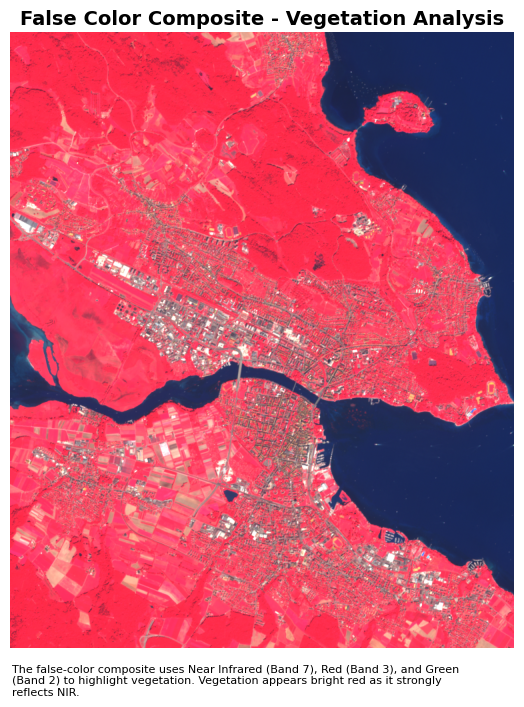

In [ ]:
import textwrap

# Create a false-color composite using specific bands: 
# Band 7 (NIR), Band 3 (Red), Band 2 (Green) for vegetation analysis
# This is often used to highlight vegetation as the NIR band (Near Infrared) strongly reflects vegetation.
plot_image(
    image[:, :, [7, 3, 2]], # NIR (Band 7), Red (Band 3), Green (Band 2)
    factor=factor*factor_multiplier,
    clip_range=(0, 1),
    figsize=(8, 8)
)

# Set title for the plot
plt.title("False Color Composite - Vegetation Analysis", fontsize=14, fontweight='bold')

# Define text description
text = (
    "The false-color composite uses Near Infrared (Band 7), Red (Band 3), and Green (Band 2) to highlight vegetation. Vegetation appears bright red as it strongly reflects NIR."
)
wrapped_text = textwrap.fill(text, width=80) 

# Add description
plt.figtext(
    0.2,
    0.07,
    wrapped_text,
    ha='left',
    va='center',
    fontsize=8,
    # wrap=True,
    backgroundcolor='w',
)

# Display the plot
plt.show()

### 6.2. Remote Sensing Indices

Remote sensing indices, such as the Normalized Difference Vegetation Index (NDVI), Normalized Difference Water Index (NDWI), and others, are widely used to analyze various environmental factors such as vegetation health, water bodies, and land cover.

For more information on how to calculate and use these indices, you can refer to the official [Sentinel Hub Custom Scripts Repositiry](https://custom-scripts.sentinel-hub.com/custom-scripts/sentinel/sentinel-2/#popular-rgb-composites)

#### 6.2.1 Normalized Difference Vegetation Index (NDVI)

The Normalized Difference Vegetation Index (NDVI) measures plant health and biomass. It is commonly used to monitor the growth and health of vegetation, as well as to identify areas of stress or damage. 

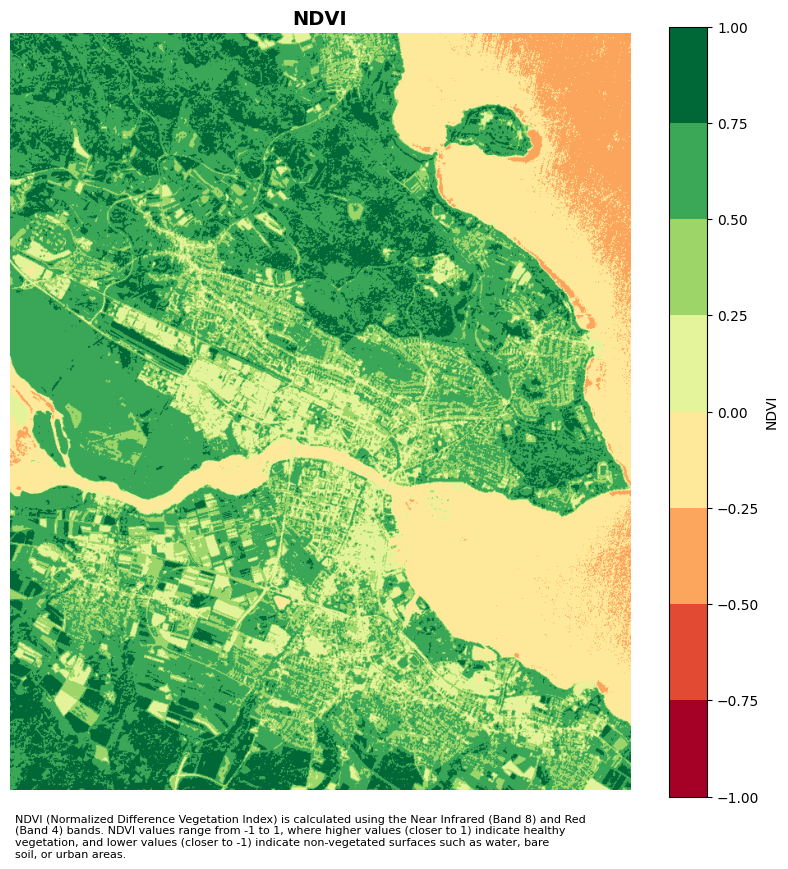

In [60]:
# Extract the NIR (Band 8) and Red (Band 4) bands from the satellite data
nir = all_bands_response_v2[0][:, :, 7]  # Band 8 (NIR)
red = all_bands_response_v2[0][:, :, 3]  # Band 4 (Red)

# Compute NDVI (Add a small number to the denominator to avoid division by zero)
ndvi = (nir - red) / (nir + red + 1e-10)

# Plot NDVI
plt.figure(figsize=(10, 10))
cmap = plt.get_cmap('RdYlGn', 8)
plt.imshow(ndvi, cmap=cmap, vmin=-1, vmax=1)

# Add a color bar
plt.colorbar(label='NDVI')

# Set the title for the plot
plt.title('NDVI', fontsize=14, fontweight='bold')

# Define the text description
text = (
    "NDVI (Normalized Difference Vegetation Index) is calculated using the Near Infrared (Band 8) and Red (Band 4) bands. "
    "NDVI values range from -1 to 1, where higher values (closer to 1) indicate healthy vegetation, and lower values (closer to -1) "
    "indicate non-vegetated surfaces such as water, bare soil, or urban areas."
)
wrapped_text = textwrap.fill(text, width=100)

# Add description
plt.figtext(
    0.13,
    0.07,
    wrapped_text,
    ha='left',
    va='center',
    fontsize=8,
    backgroundcolor='w',
)

# Remove axis ticks for a cleaner display
plt.axis('off')

# Display the plot
plt.show()

#### 6.2.2 Normalized Difference Moisture Index (NDMI)

The Normalized Difference Moisture Index (NDMI) is a key indicator for monitoring vegetation water content. It helps assess plant health, detect drought stress, and evaluate irrigation efficiency

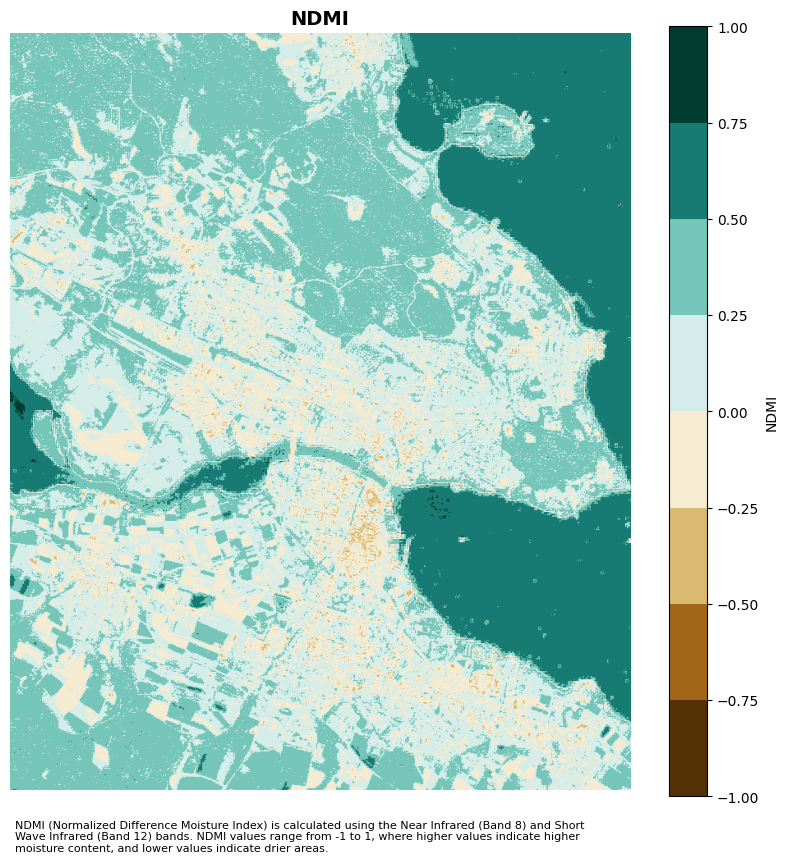

In [62]:
# Extract the NIR (Band 8) and SWIR (Band 12) bands from the satellite data
nir = all_bands_response_v2[0][:, :, 7]  # Band 8 (NIR)
swir = all_bands_response_v2[0][:, :, 11]  # Band 12 (SWIR)

# Compute NDMI (Add a small number to the denominator to avoid division by zero)
ndmi = (nir - swir) / (nir + swir + 1e-10)

# Plot NDMI
plt.figure(figsize=(10, 10))
cmap = plt.get_cmap('BrBG', 8)  # Adjusted color map for NDMI
plt.imshow(ndmi, cmap=cmap, vmin=-1, vmax=1)

# Add a color bar
plt.colorbar(label='NDMI')

# Set the title for the plot
plt.title('NDMI', fontsize=14, fontweight='bold')

# Define the text description
text = (
    "NDMI (Normalized Difference Moisture Index) is calculated using the Near Infrared (Band 8) and Short Wave Infrared (Band 12) bands. "
    "NDMI values range from -1 to 1, where higher values indicate higher moisture content, and lower values indicate drier areas."
)
wrapped_text = textwrap.fill(text, width=100)

# Add description
plt.figtext(
    0.13,
    0.07,
    wrapped_text,
    ha='left',
    va='center',
    fontsize=8,
    backgroundcolor='w',
)

# Remove axis ticks for a cleaner display
plt.axis('off')

# Display the plot
plt.show()

#### 6.2.3 Surface Albdo

Albedo is a measure of the reflectivity of a surface, which indicates how much sunlight is reflected by a surface compared to how much is absorbed. It is crucial for understanding surface energy balance, heat distribution, and land cover properties. In remote sensing, albedo is often used to study changes in surface characteristics such as snow cover, vegetation, or urbanization.

Albedo values range from 0 (no reflection, total absorption) to 1 (total reflection), with higher albedo indicating more reflective surfaces (such as snow or ice) and lower albedo indicating darker surfaces (such as forests or oceans).

Reference: [Albedo Retrieval From Sentinel-2](https://doi.org/10.1109/LGRS.2020.2967085)

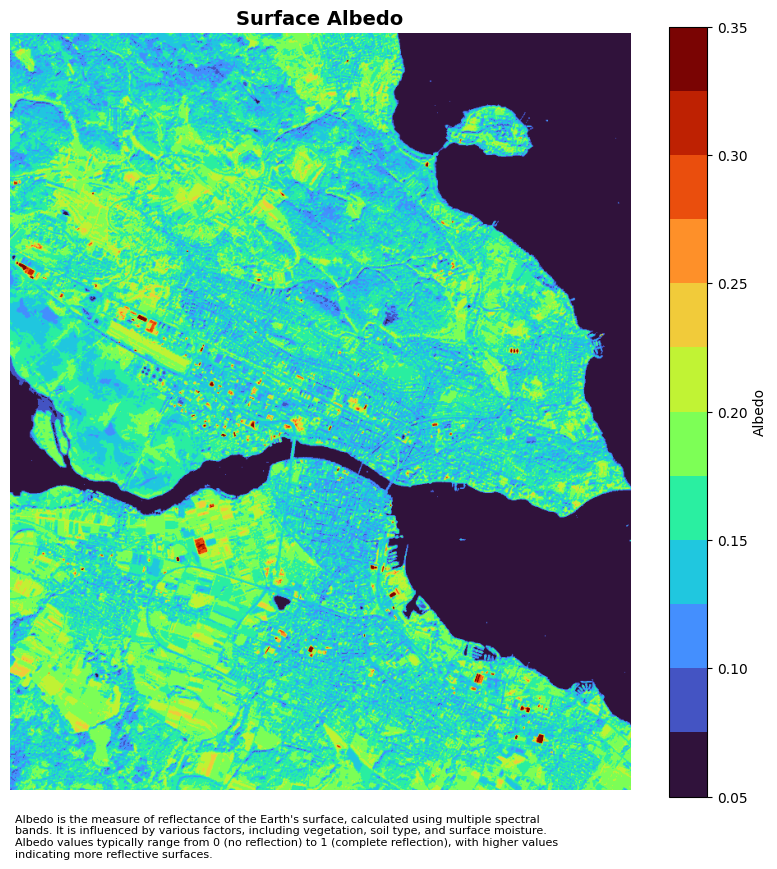

In [69]:
# Extract the bands and convert DN to reflectance (DN = 10000 * REFLECTANCE)
B02 = all_bands_response_v2[0][:, :, 1] / 10000.0  # Blue
B03 = all_bands_response_v2[0][:, :, 2] / 10000.0  # Green
B04 = all_bands_response_v2[0][:, :, 3] / 10000.0  # Red
B08 = all_bands_response_v2[0][:, :, 7] / 10000.0  # NIR
B11 = all_bands_response_v2[0][:, :, 11] / 10000.0 # SWIR1
B12 = all_bands_response_v2[0][:, :, 12] / 10000.0 # SWIR2

# Calculate Albedo using the weights for each band
albedo = (B02 * 0.2266) + (B03 * 0.1236) + (B04 * 0.1573) + \
         (B08 * 0.3417) + (B11 * 0.1170) + (B12 * 0.0338)
         
# Set albedo range for visualization
vmin = 0.05
vmax = 0.35
interval = 0.025

# Plot Albedo
plt.figure(figsize=(10, 10))
cmap = plt.get_cmap('turbo', int((vmax-vmin)/interval)+1)
plt.imshow(albedo, cmap=cmap, vmin=vmin, vmax=vmax)

# Add a color bar
plt.colorbar(label='Albedo')

# Set the title for the plot
plt.title('Surface Albedo', fontsize=14, fontweight='bold')

# Define the text description
text = (
    "Albedo is the measure of reflectance of the Earth's surface, calculated using multiple spectral bands. "
    "It is influenced by various factors, including vegetation, soil type, and surface moisture. Albedo values typically range "
    "from 0 (no reflection) to 1 (complete reflection), with higher values indicating more reflective surfaces."
)
wrapped_text = textwrap.fill(text, width=100)

# Add description
plt.figtext(
    0.13,
    0.07,
    wrapped_text,
    ha='left',
    va='center',
    fontsize=8,
    backgroundcolor='w',
)

# Remove axis ticks for a cleaner display
plt.axis('off')

# Display the plot
plt.show()

## 7. Supplements

In remote sensing analysis, several supplementary indices or techniques can be applied to extract meaningful information from satellite imagery. These indices can complement primary analyses (such as albedo or NDVI) to offer insights into land cover, vegetation health, water stress, and other environmental parameters. 

Additional indices can be found at [Sentinel-2 Index Database](https://custom-scripts.sentinel-hub.com/custom-scripts/sentinel-2/indexdb/)

For a better understanding of the Sentinel-2 band characteristics, you can refer to the following source for more detailed information [Sentinel-2 Band Characteristics](https://www.researchgate.net/figure/Sentinel-2-band-characteristics_tbl1_314119510)

In [70]:
# Data for Sentinel-2 bands
data = {
    "Band Name": ["B01", "B02", "B03", "B04", "B05", "B06", "B07", "B08", "B8A", "B09", "B10", "B11", "B12"],
    "Wavelength (nm)": [443, 490, 560, 665, 705, 740, 783, 842, 865, 945, 1375, 1610, 2190],
    "Resolution (m)": [60, 10, 10, 10, 20, 20, 20, 10, 20, 60, 60, 20, 20],
    "Description": [
        "Aerosol",
        "Blue",
        "Green",
        "Red",
        "Red Edge 1",
        "Red Edge 2",
        "Red Edge 3",
        "Near Infrared (NIR)",
        "Narrow NIR",
        "Water vapor",
        "Cirrus",
        "Shortwave Infrared (SWIR) - 1",
        "Shortwave Infrared (SWIR) - 2"
    ],
    "Alternative Desc.": [
        "Coastal aerosol",
        "Blue",
        "Green",
        "Red",
        "Vegetation red edge",
        "Vegetation red edge",
        "Vegetation red edge",
        "NIR",
        "Vegetation red edge",
        "Water vapour",
        "SWIR - Cirrius",
        "SWIR",
        "SWIR"
    ]
}

# Create a DataFrame
bands_table = pd.DataFrame(data)

# Display the table
bands_table

Band Name  Wavelength (nm)  Resolution (m)                    Description  \
0        B01              443              60                        Aerosol   
1        B02              490              10                           Blue   
2        B03              560              10                          Green   
3        B04              665              10                            Red   
4        B05              705              20                     Red Edge 1   
5        B06              740              20                     Red Edge 2   
6        B07              783              20                     Red Edge 3   
7        B08              842              10            Near Infrared (NIR)   
8        B8A              865              20                     Narrow NIR   
9        B09              945              60                    Water vapor   
10       B10             1375              60                         Cirrus   
11       B11             1610              20  Shortwave Infrared (SWIR) - 1   
12       B12             2190              20  Shortwave Infrared (SWIR) - 2   

      Alternative Desc.  
0       Coastal aerosol  
1                  Blue  
2                 Green  
3                   Red  
4   Vegetation red edge  
5   Vegetation red edge  
6   Vegetation red edge  
7                   NIR  
8   Vegetation red edge  
9          Water vapour  
10       SWIR - Cirrius  
11                 SWIR  
12                 SWIR